In [82]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [83]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [84]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [85]:
df.tail()

,RSCCASN
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [86]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

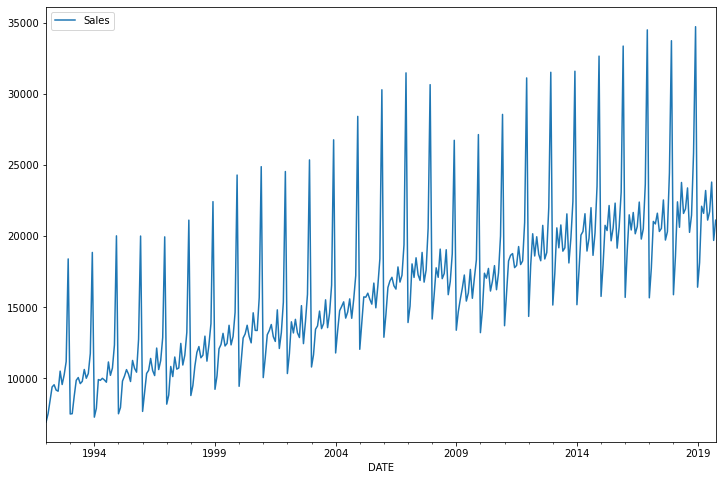

In [47]:
df.plot(figsize=(12,8))

## Répartition Entraînement / Test

In [48]:
len(df)

334

Les données sont mensuelles, prévoyons un an et demi dans le futur.

In [49]:
len(df)- 12

322

In [50]:
test_size = 12

In [51]:
test_ind = len(df)- test_size

In [52]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [53]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381


## ARIMA model

### l'implémentation d'un baseline model 

In [54]:
def add_Date_column(df):
    df['Date'] = df.index.values
    df.index = range(0, len(df), 1)
    return df

In [55]:
df_copy = df.copy()
df_copy = add_Date_column(df_copy)
df_copy

,Sales,Date
0,6938,1992-01-01
1,7524,1992-02-01
2,8475,1992-03-01
3,9401,1992-04-01
4,9558,1992-05-01
...,...,...
329,21123,2019-06-01
330,21714,2019-07-01
331,23791,2019-08-01
332,19695,2019-09-01


In [56]:
train_copy = df_copy[:-12]
test_copy = df_copy[-12:]
test_copy

,Sales,Date
322,25831,2018-11-01
323,34706,2018-12-01
324,16410,2019-01-01
325,18134,2019-02-01
326,22093,2019-03-01
327,21597,2019-04-01
328,23200,2019-05-01
329,21123,2019-06-01
330,21714,2019-07-01
331,23791,2019-08-01


In [57]:
test_copy.loc[:, "baseline_pred"] = train_copy['Sales'][-12:].values

In [58]:
test_copy

,Sales,Date,baseline_pred
322,25831,2018-11-01,24438
323,34706,2018-12-01,33720
324,16410,2019-01-01,15881
325,18134,2019-02-01,18585
326,22093,2019-03-01,22404
327,21597,2019-04-01,20616
328,23200,2019-05-01,23764
329,21123,2019-06-01,21589
330,21714,2019-07-01,21919
331,23791,2019-08-01,23381


On utiliser MAPE (Mean Absolute Percent Error) comme métrique

In [59]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [60]:
mape_baseline_pred = mape(test_copy["Sales"], test_copy["baseline_pred"])
print("MAPE = %.2f %%" %mape_baseline_pred)

MAPE = 2.65 %


On utiliser MAPE (Mean Absolute Percent Error) comme métrique

In [61]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_copy['Sales'], test_copy['baseline_pred'])
rmse = np.sqrt(mse)
print("rmse :",rmse)

rmse : 686.122620236354


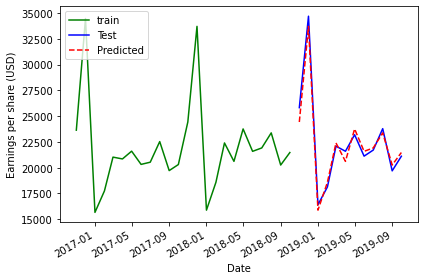

In [62]:
fig, ax = plt.subplots()
ax.plot(train_copy["Date"][-24:], train_copy['Sales'][-24:], '-g', label = 'train')
ax.plot(test_copy["Date"], test_copy["Sales"], 'b-', label = 'Test')
ax.plot(test_copy['Date'], test_copy['baseline_pred'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()

### l'implémentation d'un modele ARIMA

###  <font color='green'>ADF test</font>

In [63]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [64]:
ADF_result = adfuller(df_copy["Sales"])
print("ADF Statistic: {}".format(ADF_result[0]))
print("p-value: {}".format(ADF_result[1]))

ADF Statistic: -0.8442558733662112
p-value: 0.8057754647419666


p-value est supérieur à 0.05 => On accept l'hypothèse nulle => notre serie est non stationnaire

###  <font color='green'>First Order differencing </font>

<AxesSubplot:xlabel='Date'>

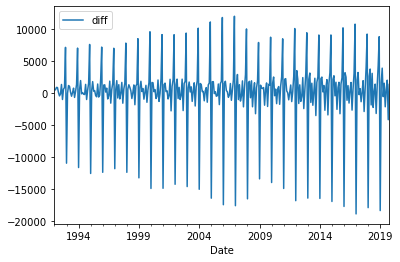

In [65]:
diff_data = np.diff(df_copy["Sales"], n=1)

df_copy.loc[1:, "diff"] = diff_data
df_copy.plot(y="diff", x = 'Date')

###  <font color='green'>second Order differencing </font>


<AxesSubplot:xlabel='Date'>

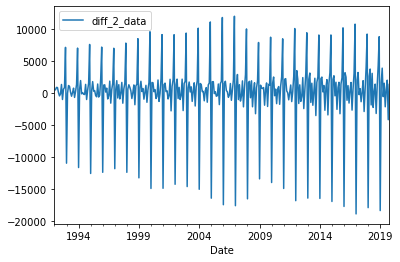

In [66]:
diff_2_data = np.diff(df_copy["Sales"], n=2)

df_copy.loc[1:, "diff_2_data"] = diff_data
df_copy.plot(y="diff_2_data", x = 'Date')

###  <font color='green'>ADF test</font>

In [67]:
print("First Order diff")
ADF_result = adfuller(diff_data)
print("ADF Statistic: {}".format(ADF_result[0]))
print("p-value: {}".format(ADF_result[1]))
print("second Order diff")
ADF_result = adfuller(diff_2_data)
print("ADF Statistic: {}".format(ADF_result[0]))
print("p-value: {}".format(ADF_result[1]))

First Order diff
ADF Statistic: -3.9006228360814554
p-value: 0.0020302681541850237
second Order diff
ADF Statistic: -11.228554599727882
p-value: 1.9330358906939433e-20


p-value est inférieure à 0.05 => On rejette l'hypothèse nulle => notre serie est stationnaire

###  <font color='green'>ACF plot</font>

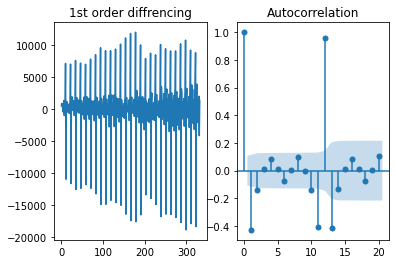

In [68]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1st order diffrencing")
ax1.plot(diff_data)

ax2 = f.add_subplot(122)
plot_acf(diff_data, lags=20, ax = ax2)
plt.show()

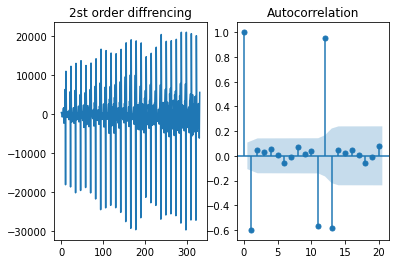

In [69]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("2st order diffrencing")
ax1.plot(diff_2_data)

ax2 = f.add_subplot(122)
plot_acf(diff_2_data, lags=20, ax = ax2)
plt.show()

###  <font color='green'>PACF plot</font>

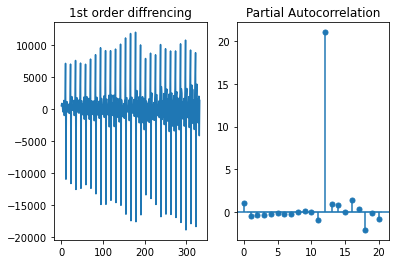

In [70]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1st order diffrencing")
ax1.plot(diff_data)

ax2 = f.add_subplot(122)
plot_pacf(diff_data, lags=20, ax = ax2)
plt.show()

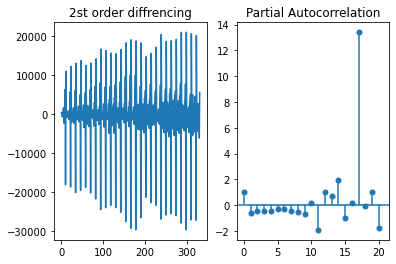

In [71]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("2st order diffrencing")
ax1.plot(diff_2_data)

ax2 = f.add_subplot(122)
plot_pacf(diff_2_data, lags=20, ax = ax2)
plt.show()

###  <font color='green'>ARIMA model</font>

In [72]:
from itertools import product

p_values = range(0, 10,1)
q_values = range(0, 10,1)
d_values = range(1, 3, 1)

order_list = list(product(p_values, d_values,  q_values))
order_list[0]

(0, 1, 0)

In [73]:
X_train = list(train_copy["Sales"])
X_test = list(test_copy["Sales"])

In [74]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

def evaluate_arima_model(X_train, X_test, arima_order):
    history = X_train
    predictions = []
    for i in range(len(X_test)):#walk forward validation
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()
        predictions.append(yhat)
        obs = X_test[i]
        history.append(obs)
    rmse = np.sqrt(mean_squared_error(X_test, predictions))
    return predictions

In [65]:
# running this might take a while 

min_rmse = np.inf
best_config = None
for config in order_list:
    try:
        rmse = evaluate_arima_model(X_train, X_test, config)
        if(rmse < min_rmse):
            min_rmse = rmse
            best_config = config
    except(e):
        continue
# best configuration is (3, 1, 8)
# min rmse is 2193 

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

NameError: name 'e' is not defined

In [67]:
min_rmse
best_config

(0, 1, 8)

In [80]:
test_copy.loc[:, "Arima_prediction"] = evaluate_arima_model(X_train, X_test,(3, 1, 8))
final_model = ARIMA(X_train, order=(3, 1, 8))
model_fit = final_model.fit()
test_copy

,Sales,Date,baseline_pred,Arima_prediction
322,25831,2018-11-01,24438,24431.609361
323,34706,2018-12-01,33720,28655.789189
324,16410,2019-01-01,15881,19871.357258
325,18134,2019-02-01,18585,18432.357341
326,22093,2019-03-01,22404,21921.226107
327,21597,2019-04-01,20616,21055.560314
328,23200,2019-05-01,23764,21966.936151
329,21123,2019-06-01,21589,20715.265426
330,21714,2019-07-01,21919,23747.659561
331,23791,2019-08-01,23381,26897.935585


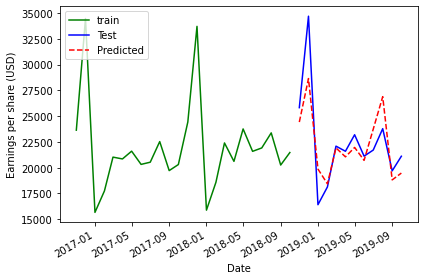

In [81]:
fig, ax = plt.subplots()
ax.plot(train_copy["Date"][-24:], train_copy['Sales'][-24:], '-g', label = 'train')
ax.plot(test_copy["Date"], test_copy["Sales"], 'b-', label = 'Test')
ax.plot(test_copy['Date'], test_copy['Arima_prediction'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()

In [37]:
residuals = model_fit.resid
residuals

array([ 6938.        ,  4514.96369985,  3451.26091894,  3464.69425104,
        3016.54365392,  2914.24766371,  1660.43911829,  5672.86918532,
        2151.5047563 ,  2605.6217909 ,  2535.36334013, 13210.31521863,
        -755.55078568, -1609.53869629, -1022.88260592,  5344.51861122,
        -954.15001852, -2074.96004349, -2266.02849656,   672.10315036,
       -1013.51195939, -1112.59114629,  -460.76901459,  6157.03015308,
       -3688.23941765, -2876.8352432 , -1097.01768702,   253.96795092,
       -1925.71598133, -1104.5643736 , -1049.16646851, -2502.03828335,
         524.6320445 ,  1762.65841985,  2245.63749345,  4997.71425345,
        -748.29005032,   114.90596992,  1056.45358396,  -517.96527449,
        1030.33475414,   782.83121567,  -330.43888653, -3786.5903873 ,
        2274.30312428,  1244.02534154,  1708.39200005,  3193.57405911,
        -603.106344  ,  -764.51963334,   106.15018891, -1381.88788669,
         686.8603902 ,  -717.16827882, -1241.88972817, -3097.89234472,
      

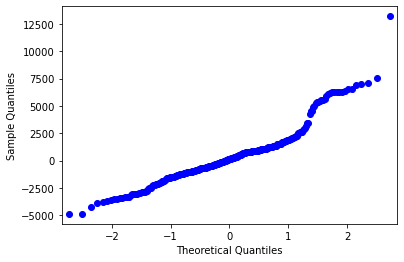

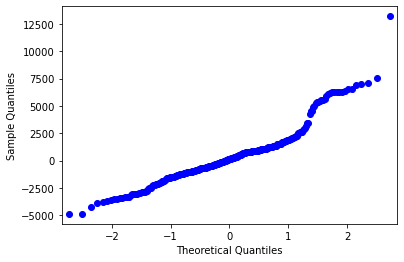

In [38]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals)

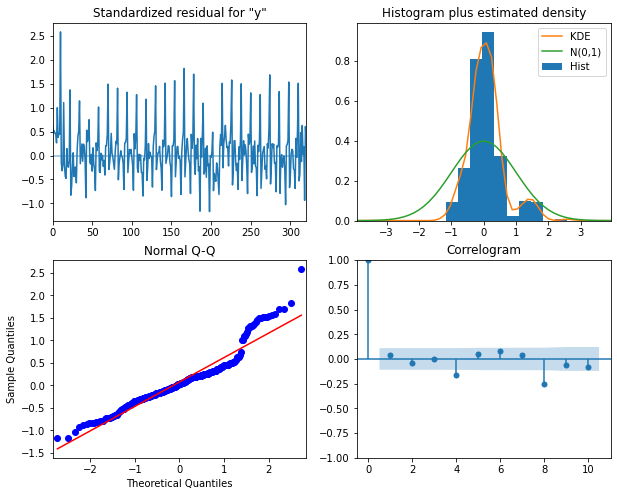

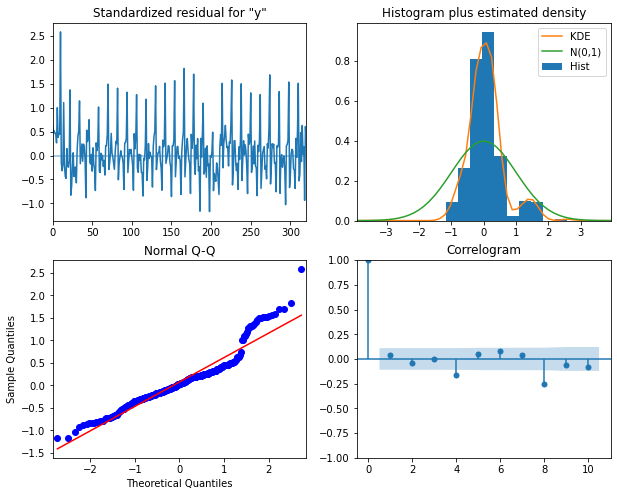

In [39]:
model_fit.plot_diagnostics(figsize=(10, 8))

le Q-Q plot est linéare + residuals ne sont pas corrélées => le model est meilleur, prés pour la prédiction 